# Hodgkin-Huxley

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from seaborn import despine
from itertools import product as itproduct

In [3]:
from neuroprobnum.utils import math_utils
from neuroprobnum.utils import plot_utils as pltu

# Model

In [4]:
from neuroprobnum.models.hodgkin_huxley import compile_cython

compile_cython()

running build_ext



In [5]:
from neuroprobnum.models.hodgkin_huxley import HHNeuron

neuron = HHNeuron()
neuron

HH_neuron

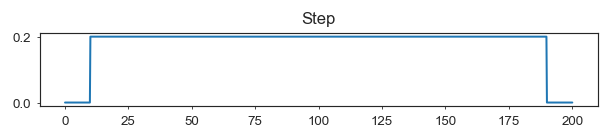

In [6]:
from neuroprobnum.utils import stim_utils
t0, tmax = 0, 200
stim_onset, stim_offset = 10, tmax-10
stim = stim_utils.IStimStep(Iamp=0.2, onset=stim_onset, offset=stim_offset, name='Step')
neuron.get_Istim_at_t = stim.get_I_at_t
stim.plot(t0=t0, tmax=tmax)

# Generator

In [7]:
from neuroprobnum.generator.generator_hh import DataGeneratorHH
    
gen = DataGeneratorHH(
    t0=t0, tmax=tmax, t_eval_adaptive=math_utils.t_arange(t0, tmax, 5),
    return_vars=['events', 'ys'],
    model=neuron, y0=neuron.compute_yinf(-65), thresh=0.0,
    n_samples=100, n_parallel=20,
    gen_det_sols=True, gen_acc_sols=True, acc_same_ts=True,
    base_folder='data/examples_hh'
)
gen.update_subfoldername(stim=stim.name)
gen.load_acc_sols_from_file()

Not acc sols file found!


## Data

In [8]:
# pert_method, adaptive, methods, step_params, pert_param
solver_params = [
    ('abdulle_ln', 0, ['EE'], [0.25], [1]),
]

In [9]:
np.random.seed(42)
  
for pert_method, adaptive, methods, step_params, pert_params in solver_params:
    for step_param, method, pert_param in itproduct(step_params, methods, pert_params):
        gen.gen_and_save_data(
            method=method, adaptive=adaptive, step_param=step_param,
            pert_method=pert_method, pert_param=pert_param, overwrite=True, allowgenerror=False,
        )

             stim_Step_tmax_200/EE_f(0.25)_abdulle_ln(1).pkl --> Generate data because file was not found.
No suited acc_ts found in 0 acc_ts. Create reference solution!
2 times the following warning: inefficient


# Load data

In [10]:
from neuroprobnum.generator.dataloader import DataLoader

df = DataLoader(gen).load_data2dataframe(solver_params, drop_traces=False, MAEs=False)
df['stimfun'] = stim
df['stim'] = stim.name
df.head()

,acc_events,acc_ts,acc_vs,adaptive,det_events,det_nODEcalls,det_run_time,det_ts,det_vs,events,...,pert_param,run_times,seed,step_param,t0,tmax,ts,vs,stimfun,stim
0,"[[11.270881645965627, 23.333899356067285, 34.9...","[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[-65.0, -64.99992457182115, -64.9998570073335,...",0,"[[11.850855243541666, 25.65387713167099, 38.90...",800.0,0.024285,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[-65.0, -64.99992555291273, -64.9998627013862,...","[[[12.007016188593497, 25.654282196452833, 39....",...,1.0,"[0.043854475021362305, 0.03276228904724121, 0....","[12475674, 1080776788, 1858585705, 1629164900,...",0.25,0.0,200.0,"[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2...","[[-65.0, -64.99993881026417, -64.9998622452679...","IStimStep(0.2,t=[10,190])",Step


### Compute KDEs

In [11]:
from neuroprobnum.utils.metric_utils import compute_kde

df[['kde', 'kde_ts']] = None

for i, row in df.iterrows():
    kde_ts = np.linspace(row.t0, row.tmax, 2001)
    df.at[i, 'kde_ts'] = kde_ts
    
try:
    from joblib import Parallel, delayed
    df['kde'] = Parallel(n_jobs=np.maximum(len(df), 10))(delayed(compute_kde)(np.concatenate([events[0] for events in row.events]), row.kde_ts, np.mean([len(e_list[0]) for e_list in row.events])) for i, row in df.iterrows())
    
except ImportError:
    for i, row in df.iterrows():
        kde = compute_kde(X=np.concatenate([events[0] for events in row.events]), kde_ts=row.kde_ts, scale=np.mean([len(e_list[0]) for e_list in row.events]))
        df.at[i, 'kde'] = kde

# Plot

In [12]:
from neuroprobnum.utils.figure_utils import plot_stim, plot_vs, plot_events, plot_kde
from neuroprobnum.utils.metric_utils import compute_kde

def plot_row(axs, row, nraster=10):
    
    assert axs.size == 5, axs.size
    
    stim_ts = np.arange(t0, tmax, 0.01)
    plot_stim(ax=axs[0], ts=stim_ts, stim=[row.stimfun.get_I_at_t(t=t) for t in stim_ts])

    plot_vs(ax=axs[1], ts=row.acc_ts, vs=row.acc_vs, c='k')
    plot_vs(ax=axs[2], ts=row.det_ts, vs=row.det_vs, c='C1')    
    plot_kde(ax=axs[3], kde_ts=row.kde_ts, kde=row.kde)
    plot_events(ax=axs[4], events=row.events[:nraster] if nraster > 0 else None, event_traces={'det.': (row.det_events[0], 'C1'), 'ref.': (row.acc_events[0], 'k')}, lw=1)
    
    pltu.make_share_xlims(axs)
    
    for ax in axs[:-1]:
        ax.set_xlabel(None)
        ax.set_xticks([])
        ax.spines['bottom'].set_visible(False)

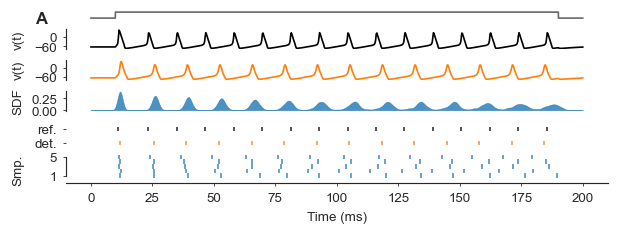

In [13]:
fig, axs = pltu.subplots(1, 5, ysizerow=0.34, yoffsize=0.3, xsize='text', gridspec_kw=dict(height_ratios=[0.08, 0.25, 0.25, 0.25, 0.75]))
despine()
  
assert len(df) == 1
plot_row(axs=axs, row=df.iloc[0], nraster=5)

# Adjust spacing
mode_spacing = 0.085
plt.tight_layout(h_pad=0.3, rect=[0, 0, 1, 1])    
pltu.set_labs(axs[0], panel_nums='auto', panel_num_space=4, panel_num_va='top', panel_num_y=1.1)
fig.align_ylabels()
fig.align_xlabels()

pltu.savefig("fig2_a")
plt.show()

# Text

In [14]:
row = df.iloc[0]

In [15]:
for i in range(3):
    error = np.abs(row.det_events[0][i] - row.acc_events[0][i])
    print(f"Det error {i} = {error:.1f}")

Det error 0 = 0.6
Det error 1 = 2.3
Det error 2 = 4.0


In [16]:
#for i in range(3):
#    errors = np.array([e_list[0][i] for e_list in row.events]) - row.acc_events[0][i]
#    print(f"Mean error of spike {i} = {np.mean(errors):.1f}")

for i in range(3):
    print(f"SD of spike {i} = {np.std([e_list[0][i] for e_list in row.events], ddof=1):.1f}")

SD of spike 0 = 0.2
SD of spike 1 = 0.9
SD of spike 2 = 1.1
